# Part 1: Data Acquisition

Dimensions of the group image: (604, 964)


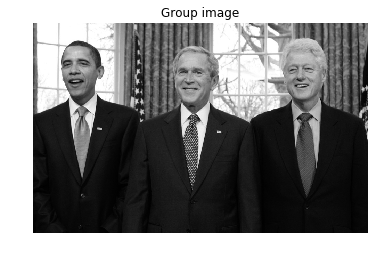

In [2]:
from matplotlib import pyplot as plt
import cv2
import os

group = cv2.imread('pres.jpg', 0)
print("Dimensions of the group image:", group.shape)
plt.imshow(group, cmap="gray");plt.axis('off')
plt.title('Group image');plt.show()

#### Describe how you selected the images with respect to the conditions of the detection/classifcation methods? 

The images were taken from an official data set [CFPW](http://www.cfpw.io/). 

The images are reltivaly small in size, less than 300x150 for most of them and were also converted to gray scale to make the calculations less intensive.

The detection methods that we will implement have their limitations and our implimentation might not be the best, so I chose images that are straight facing forward without any distractions. Also the group image was somewhat similar to the individual images.

Detecting using eigenVectors has its limitations because it is prone to finding false-positives if the data is not well clustered or if the training images are not very close to each other.

PCA normally foucses in the 'mean' or 'shared' features of a set of images. In the case of a face, I made sure that all of my training images contain only faces. 

# Part 2: Eigenvector Representation

#### PCA to find the eigenvector representation of your training data


(30, 10000)


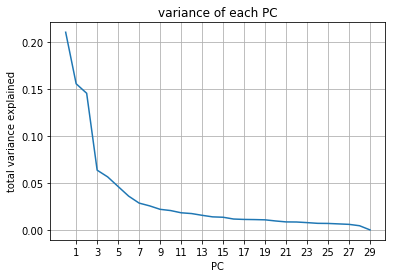

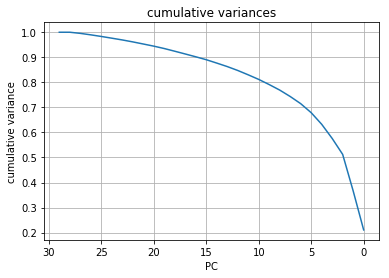

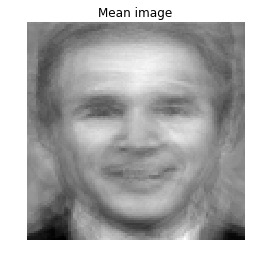

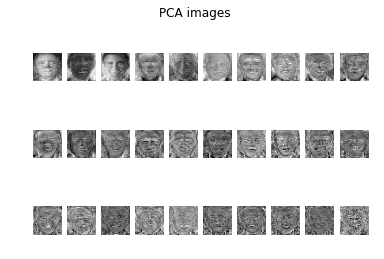

In [3]:
"""
Some of the logic below was inspired by: 
https://github.com/spmallick/learnopencv/tree/master/ReconstructFaceUsingEigenFaces
https://www.learnopencv.com/face-reconstruction-using-eigenfaces-cpp-python/
"""

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

# Target values (messi = 0, xavi = 1, neymar = 2)
# Results array has shape:
# [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
target = np.concatenate((np.zeros(10), np.ones(10), (np.ones(10)+1)), axis=0).astype(int)

# Read images from folders and resize to 300x300
messi = [cv2.resize(cv2.imread('obama/o' + str(i) + '.jpg', 0), (100, 100)) for i in range(1,11)]
xavi = [cv2.resize(cv2.imread('bush/b' + str(i) + '.jpg', 0), (100, 100)) for i in range(1,11)]
neymar = [cv2.resize(cv2.imread('clinton/c' + str(i) + '.jpg', 0), (100, 100)) for i in range(1,11)]

# Concatenate all images into one array
images = np.concatenate((messi, xavi, neymar), axis=0)

# mean image
mean_img = images.mean(0)

# Flatten images
images = [im.flatten() for im in images]

print(np.array(images).shape)

# Initialize PCA object
pca = PCA(n_components = 30)

# Fit the PCA and return the data using pca.fit_transform( ... )
images_pca = pca.fit_transform( images )

# Return an array of the variances of the each component saperately
var = pca.explained_variance_ratio_

# Plot the variance explained by each componenet of the 30 componenets
plt.plot(var)
plt.xlabel('PC')
plt.ylabel('total variance explained')
plt.xticks(np.arange(1, 30, 2.0))
plt.title('variance of each PC')
plt.grid(True)
plt.show()


#comulative variance
v = 0
cumulative_var = []
for va in var:
    v += va
    cumulative_var.append(v)

plt.plot(cumulative_var)
plt.xlabel('PC')
plt.ylabel('cumulative variance')
plt.title('cumulative variances')
plt.gca().invert_xaxis()
plt.grid(True); plt.show();

# Find eigen vector representation of each image
mean, eigenVectors = cv2.PCACompute(np.array(images), mean=None)

# Plot mean image
plt.imshow(mean_img, cmap="gray");plt.axis('off')
plt.title('Mean image');plt.show()

# Plot eigenvector images
for i in range(len(images)):
    plt.suptitle("PCA images")
    plt.subplot(3,10,i+1)
    plt.imshow(eigenVectors[i].reshape(100,100), cmap='gray')
    plt.axis('off')
plt.show()

#### Do you need all the vectors to represent the data? 

No. PCA allows us to "compress" the data into a much smaller size by only taking a fraction of the vectors. As seen in the cumulative variance graph, around 12 PCs give about 85% percent of the information of the original data.

#### How well clustered is the data? 

Relatively well clustered. More explanantion and grapwill come later.

###### For every sample, find the nearest neighbour (L2 distance), and check whether it is of the same class.

###### 1- Original pixel space:

In [186]:
from sklearn.neighbors import KNeighborsClassifier as knc

#K Neighbors Classifier (knc)
knn = knc(n_neighbors = 3)

#split training data and targets
X_train, X_test, y_train, y_test = train_test_split(images, target)

#fit model
knn.fit(X_train, y_train)

predicted = knn.predict(images)

print("target   :",target)
print("pridected:",predicted)
######## K NEIGHBORS TESTING

# Find accuracy of results
good = 0
for i in range(len(predicted)):
    if predicted[i] == target[i]:
        good += 1
print("accuracy is", good, "out of 30")

target   : [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
pridected: [0 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 1 2 1 0]
accuracy is 25 out of 30


###### 2- Eignespace

In [146]:
# Transform images
pcas = pca.transform(images)

sum_pcas = np.array([abs(sum(x)) for x in pcas])

#K Neighbors Classifier (knc)
knn1 = knc(n_neighbors = 3)

#split training data and targets
X_train1, X_test1, y_train1, y_test1 = train_test_split(pcas, target)

#fit model
knn1.fit(X_train1, y_train1)

predictions_pca = knn1.predict(pcas)

print("target   :",target)
print("predicted:",predictions_pca)

# Find accuracy of results
good_pca = 0
for i in range(len(predictions_pca)):
    if predictions_pca[i] == target[i]:
        good_pca += 1
print("accuracy is", good_pca, "out of 30")

target   : [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
predicted: [0 0 0 0 0 0 0 0 0 0 2 1 1 1 0 1 1 1 1 1 2 2 2 2 2 2 0 2 1 0]
accuracy is 25 out of 30


#### Data clusters:

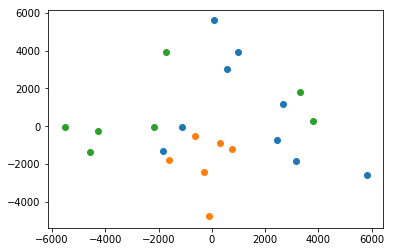

In [210]:
X_train_pca = pca.fit_transform( X_train1 )

X_class_0 = X_train_pca[ y_train1 == 0, :]
X_class_1 = X_train_pca[ y_train1 == 1, :]
X_class_2 = X_train_pca[ y_train1 == 2, :]

plt.figure()
plt.scatter(X_class_0[:,0], X_class_0[:,1])
plt.scatter(X_class_1[:,0], X_class_1[:,1])
plt.scatter(X_class_2[:,0], X_class_2[:,1])
plt.show()

###### compare the values (original vs eigen); would you expect there to be a significant difference?

They predictions are nearly identicals in most cases. We wouldn't expect there to be much difference because all we did was to compress the data.

# Part 3: Face Detection & Identification

#### Detection:

In [187]:
"""
Some of the logic below was inspired by: 
https://github.com/spmallick/learnopencv/tree/master/ReconstructFaceUsingEigenFaces
https://www.learnopencv.com/face-reconstruction-using-eigenfaces-cpp-python/
"""


# Find mean face
mean_face = mean_img.copy()

# Normalized faces
# images_norm = images - mean_face

mean = np.array(mean).flatten()
eigenFaces = [] 
for eigenVector in eigenVectors:
    eigenFace = eigenVector.reshape((100,100))
    eigenFaces.append(eigenFace)
eigenFaces = np.array(eigenFaces)

op=[]
def detect(subimage):
    imVector = subimage - mean_face
    output = imVector.mean(0)
    imV= imVector.flatten()
    
    for i in range(len(eigenFaces)):
        product= np.dot( eigenVector[i].T, imVector)
        weight = np.dot(eigenFaces[i].T,product)
        output = output + (eigenVector[i] * weight)        
    error= imVector-output
    return abs(error.sum())

errors = []
maybe_face = []
for x in range(0,group.shape[1]-101,50):
    for y in range(0,group.shape[0]-101,50):
        sub = cv2.resize(group[y:y+100, x:x+100], (100,100))
        err = detect(sub)
        errors.append([x,y,err])
        if err < 3:
            maybe_face.append([x,y,err])

Number of 'suspected' faces: 6


6 'expected faces' found
Error: 0.4000470949904411
(x,y) location: 50 100


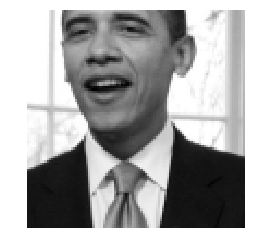

Error: 0.6114142818332766
(x,y) location: 100 250


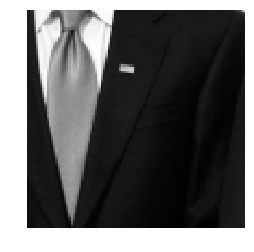

Error: 2.5783598064290345
(x,y) location: 350 100


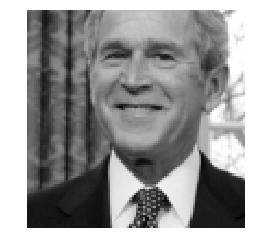

Error: 2.8203537208792113
(x,y) location: 400 150


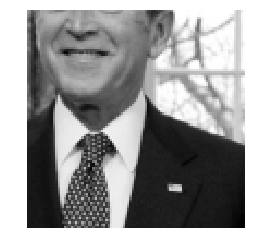

Error: 2.414818420249503
(x,y) location: 450 0


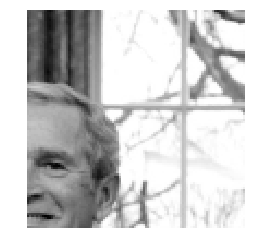

Error: 2.9635139024185264
(x,y) location: 750 150


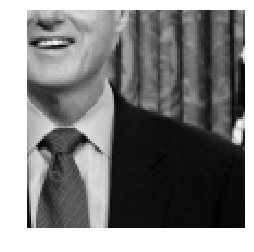

In [188]:
print(len(maybe_face), "'expected faces' found")
detected = group.copy()
windows = []
for c in (maybe_face):
    y = c[1]
    x = c[0]
    im = cv2.resize(group[y:y+200, x:x+200], (100,100))
    windows.append(im)
    print("Error:", c[2])
    print("(x,y) location:", x,y)
    plt.imshow(im, cmap="gray");plt.axis('off');plt.show()

#### Identification:

In [190]:
# Reconstruct "maybe_face"
mapped_win = []
for face in windows:
    ## Similar to the detect method ##
    imVector = face - mean_face
    output = imVector.mean(0)
    imV= imVector.flatten()
    
    for i in range(len(eigenFaces)):
        product= np.dot( eigenVector[i].T, imVector)
        weight = np.dot(eigenFaces[i].T,product)
        output = output + (eigenVector[i] * weight)
    
    mapped_win.append(abs(output).flatten())


# Find nearest neighbor of each window from the data above
#K Neighbors Classifier (knc)
knn2 = knc(n_neighbors = 5)

#split training data and targets
X_train2, X_test2, y_train2, y_test2 = train_test_split(eigenVectors, target)

#fit model
knn2.fit(X_train2, y_train2)

predictions_mapped = knn2.predict(mapped_win)

print(predictions_mapped)

[0 0 2 0 0 1]


###### accuracy of predictions:
Compare to the imageas found in the previous cell:
- First image: Obama (0)
- Second image: false positive
- Third image: Bush (1)
- Fourth image: false positive
- Fifth image: false positive
- Sixth image: nearly Clinton (2)

One out of the three positive results were correctly identified. I tried increasing the neighbours but the algorithm still didn't indntify "Bush"

# Part 4: Viola-Jones Comparison

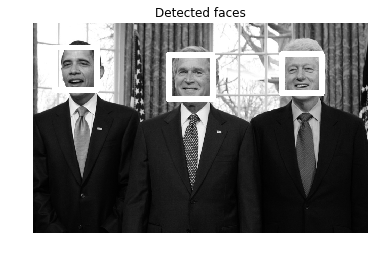

In [207]:
data_path = cv2.data.haarcascades
face_cascade = cv2.CascadeClassifier( os.path.join(data_path, 'haarcascade_frontalface_default.xml'))

img = group.copy()

faces = face_cascade.detectMultiScale(img, 1.3,7)

for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 15)
    
# display images
plt.imshow(img, cmap="gray");plt.title("Detected faces"); plt.axis('off');plt.show()

##### Use an existing implementation of the Viola-Jones face detector, and compare the results with your detector (e.g. how many false positives do you obtain?). Under what conditions would you expect the Viola-Jones detector to work when PCA does not?

The algorithm above doesn't find any false positives in the group image for the paraemetrs scaleFactor=1.3, minNeighbors=7. Lowering these parameters causes the algorithm to find one false positive.

As said before, PCA normally foucses in the 'mean' or 'shared' features of a set of images and ignores the variabilities in these images. Therefore, it might not be suitable for real-time detection of moving objects like in self-driving cars. Viola-Jones would work for a real-time moving object because doesn't focus only on the 'shared' features of the object we that we want to detect.